In [1]:
import pandas as pd
from datetime import datetime
import shapefile
import csv
import numpy as np
from __future__ import division
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split
from patsy import dmatrices

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import auc

import pickle
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing as prp
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from pylab import *
import time
from datetime import datetime

### Load data

In [73]:
with open('full_data.pkl','r') as f:
    df_full = pickle.load(f)
    
df_bikeid = pd.read_csv('bikeids.csv') # database sorted chronologically and by bike id

### Reformat and add columns

In [19]:
# Hour of the day column
df_bikeid['starttime_time'] = df_bikeid['starttime'].map(lambda x: time.strptime(x, "%Y-%m-%d %H:%M:%S").tm_hour*60 + 
                                      time.strptime(x, "%Y-%m-%d %H:%M:%S").tm_min)

# create 'over_hr' column (1 if yes, 0 if no)
df_bikeid['over_45'] = df_bikeid.tripduration.map(lambda x: 1 if x>2700 else 0)

week   = ['Monday', 
              'Tuesday', 
              'Wednesday', 
              'Thursday',  
              'Friday', 
              'Saturday','Sunday']

# Column for day of the week (0-6)
df_bikeid['day_start']=df_bikeid['starttime'].map(lambda x: week[datetime.strptime(x, "%Y-%m-%d %H:%M:%S").weekday()])

# To datetime objects
df_bikeid['starttime'] = df_bikeid['starttime'].map(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
df_bikeid['stoptime'] = df_bikeid['stoptime'].map(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

# shift data down
t = df_bikeid.shift(1)
t = t[['stoptime','end_station_id','n2','day_start','bikeid']]
t.columns = [x+"_" for x in t.columns]

# add a shifted-down version of the database to itself, to analyze rebalancing ratio
df_bikes = pd.concat((t,df_bikeid),1) 

In [21]:
len(df_bikes)

876784

In [23]:
# Remove overlaps of bikes
df_bikes = df_bikes[df_bikes['bikeid_']==df_bikeid['bikeid']]

# Create time lapse and same station column
df_bikes['time_lapsed'] = df_bikes.apply(lambda row: (row['starttime'] - row['stoptime_']), axis=1)
df_bikes['same_station'] = df_bikes.apply(lambda row: True if row['end_station_id_'] == row['start_station_id'] else False, axis=1)

# Remove buggy trips (where bike departs before it's been dropped off)
bad_bikes = df_bikes[df_bikes['time_lapsed']<0].bikeid.unique()
df_good_bikes = df_bikes[-df_bikes['bikeid'].isin(bad_bikes)]

### Various pickling of database versions and modeling results

In [26]:
with open('bikeid_data_good.pkl','wb') as f:
    pickle.dump(df_good_bikes,f)
    
with open('model_results_1.pkl','r') as f:
    r_1 = pickle.load(f)
    
with open('bikeid_data_good.pkl','r') as f:
    df = pickle.load(f)

In [76]:
# full dataset: df

# only subscribers have gender and birth year information
# subset to include those features, and disregard birth years before 1915
df_sub = df_full[(df_full['birth_year']>1915.0) & (df_full['usertype']=='Subscriber') 
                 & (df_full['gender']!=0)& (df_full['tripduration']<=3600)]  

print len(df_full)
print len(df_sub)

876785
849168


In [30]:
# convert cumulative trip duration variable into float for future analysis
df['cum_amt'] = df['cum_amt'].map(lambda f : float(f)) 

### Split data into features and response variable

In [82]:
def assign_train_test(df_any, sub=True):
    '''Assign y and X. 
    Dummify categorical variables (neighborhood, weekday, gender).
    Standardize continuous variables.
    Returns train and test subsets'''
    
    # response variable is destination neighborhood
    
    # features depend on whether analysis on all data or subscriber data
    
    # Subscriber data, classification (includes information we would only know after the fact)
    if sub==True:
        y = df_any['n2']
        cols_n = ['tripduration','birth_year','starttime_time','docks_y'] # features to Standardize
        cols_c = ['n1','gender','day_start'] # categorical features
    
    # All data (subscribers and customers)
    elif sub==False:
        y = df_any['n2']
        cols_n = ['tripduration','starttime_time','docks_y'] # features to Standardize
        cols_c = ['n1','day_start','usertype'] # categorical features. include usertype as feature
    
    # Bikeid data (to predict rebalancing)
    elif sub=='bikes':
        y = df_any['same_station']
        cols_n = ['cum_amt']
        cols_c = ['n2_','day_start_']
    
    # Subscriber data, real prediction (excludes information we would only know after the fact)
    else:
        y = df_any['n2']
        cols_n = ['birth_year','starttime_time'] # features to Standardize
        cols_c = ['gender','day_start','n1']
    
    X = df_any[cols_n + cols_c]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
    
    scaler = StandardScaler() # Standardize continuous variables
    scaler.fit(X_train[cols_n]) # Fit standardization rule to training data
        
    # continous variable treatment
    X_train_1 = pd.DataFrame(scaler.transform(X_train[cols_n]), columns=cols_n)
    X_test_1 = pd.DataFrame(scaler.transform(X_test[cols_n]), columns=cols_n)
    
    # categorical variables
    X_train_2 = pd.get_dummies(X_train[cols_c], columns = cols_c)
    X_test_2 = pd.get_dummies(X_test[cols_c], columns = cols_c)
    
    # bring 'em together
    X_train = pd.concat((X_train_1.reset_index(drop=True),X_train_2.reset_index(drop=True)),1)
    X_test = pd.concat((X_test_1.reset_index(drop=True),X_test_2.reset_index(drop=True)),1)
    
    return X_train, X_test, y_train, y_test

In [83]:
X_train, X_test, y_train, y_test = assign_train_test(df_sub, sub = "hey")

In [84]:
def conf_matrix(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train) # fit model
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)
    
    t0 = time()
    pred = clf.predict(X_test) # predict 
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)
    
    return confusion_matrix(y_test, pred, labels=['True','False'])

In [86]:
# Function to fit model, print training time and prediction time, 
# then print accuracy, classification report and feature importances

def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time.time()
    clf.fit(X_train, y_train) # fit model
    train_time = time.time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time.time()
    pred = clf.predict(X_test) # predict 
    test_time = time.time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred) # accuracy
    print("accuracy:   %0.3f" % score)
    
    prec, rec, f1, _ = precision_recall_fscore_support(y_test,pred, average = 'weighted')
    
    try:
        feats = clf.feature_importances_
        indices = np.argsort(feats)[::-1]
        print("Feature ranking:")
        for f in range(len(feats)):
            print("%d. feature %d (%f)" % (f + 1, indices[f], feats[indices[f]]))
    
    except:
        feats = 0
            
    clf_descr = str(clf).split('(')[0] # string name of classifier
    return clf_descr, score, prec, rec, f1, feats

In [66]:
# Calculate confusion matrix for Extra Trees Classifier

cm = []
clf, name = (ExtraTreesClassifier(n_estimators = 15, class_weight = 'auto', 
                              n_jobs = -1, random_state = 0), "Extra Trees")
print('=' * 80)
print(name)
cm.append(conf_matrix(clf))

Extra Trees
________________________________________________________________________________
Training: 
ExtraTreesClassifier(bootstrap=False, class_weight='auto', criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
train time: 73.518s
test time:  3.039s


In [87]:
# Compute accuracy, other scores and feature importances for certain models

results = []
for clf, name in (
        (RandomForestClassifier(n_estimators = 10, n_jobs = -1, class_weight='auto'), 
         "Random Forest"),
        (ExtraTreesClassifier(n_estimators = 10, class_weight = 'auto', 
                              n_jobs = -1, random_state = 0), "Extra Trees")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight='auto', criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
train time: 66.496s
test time:  94.806s
accuracy:   0.280
Feature ranking:
1. feature 1 (0.609320)
2. feature 0 (0.279420)
3. feature 26 (0.005975)
4. feature 14 (0.005528)
5. feature 47 (0.005497)
6. feature 45 (0.005117)
7. feature 7 (0.004486)
8. feature 32 (0.004458)
9. feature 6 (0.004286)
10. feature 5 (0.003999)
11. feature 4 (0.003977)
12. feature 3 (0.003796)
13. feature 8 (0.003774)
14. feature 10 (0.003706)
15. feature 19 (0.003586)
16. feature 12 (0.003573)
17. feature 2 (0.003515)
18. feature 9 (0.003500)
19. featur

In [26]:
# Example of feature importances

sorted(zip(X_test.columns,results[1][5]),key=lambda x: x[1])

[('n1_Upper East Side', 0.00019325624059930816),
 ('n1_NoHo', 0.00026732565467902595),
 ('n1_Nolita', 0.00050902218900905378),
 ('n1_Flatiron District', 0.00053996630692004755),
 ('n1_Gramercy', 0.00055692651562717151),
 ('n1_SoHo', 0.00058609222664374281),
 ('n1_Two Bridges', 0.00066101030209272883),
 ('n1_Stuyvesant Town', 0.00068181468004121235),
 ('n1_Greenwich Village', 0.00075810590108375462),
 ('n1_Civic Center', 0.00078975764971775614),
 ('n1_Kips Bay', 0.0008780343377673206),
 ('n1_Upper West Side', 0.00092771249378156612),
 ('n1_Park Slope', 0.00094583835301456415),
 ('n1_Chinatown', 0.00095261016507811633),
 ('n1_Columbia St', 0.00095633640041965372),
 ('n1_Murray Hill', 0.00098447232021718297),
 ('n1_West Village', 0.0011898586177665109),
 ('n1_Navy Yard', 0.0012000819328440581),
 ('n1_Theater District', 0.0012924719175718283),
 ('n1_East Village', 0.0016568667730339072),
 ('n1_Boerum Hill', 0.0017123130025766616),
 ('day_start_Tuesday', 0.0017546081288004074),
 ('n1_Lower 

In [68]:
# More models to run
# Perceptron is the same as Stochastic Gradient Descent with certain parameters:
# SGDClassifier(loss=”perceptron”, eta0=1, learning_rate=”constant”, penalty=None)

results = []

for clf, name in (
        (DecisionTreeClassifier(class_weight='auto'), "Decision Tree"),
        (Perceptron(n_jobs = -1, n_iter = 10, class_weight = 'auto'), "Perceptron"),
        (LogisticRegression(class_weight = 'auto'), "Logistic"),
        (SGDClassifier(class_weight = 'auto', n_jobs = -1, random_state = 1), 
         "Stochastic Gradient Descent")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
results.append(benchmark(Pipeline([
  ('feature_selection', LinearSVC(penalty = 'l1',dual=False, tol=1e-3, class_weight = 'auto')),
  ('classification', RandomForestClassifier(n_estimators = 5))
])))

Decision Tree
________________________________________________________________________________
Training: 
DecisionTreeClassifier(class_weight='auto', criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
train time: 83.748s
test time:  0.354s
accuracy:   0.765
Feature ranking:
1. feature 0 (0.865364)
2. feature 44 (0.014514)
3. feature 39 (0.014231)
4. feature 43 (0.012056)
5. feature 42 (0.011769)
6. feature 38 (0.008761)
7. feature 6 (0.007424)
8. feature 30 (0.007316)
9. feature 40 (0.007182)
10. feature 22 (0.006011)
11. feature 41 (0.004719)
12. feature 17 (0.004138)
13. feature 21 (0.003803)
14. feature 23 (0.003159)
15. feature 26 (0.002866)
16. feature 31 (0.002478)
17. feature 8 (0.002311)
18. feature 34 (0.002159)
19. feature 18 (0.001911)
20. feature 9 (0.001519)
21. feature 36 (0.001518)
22. feature 13 (0.001461)


In [37]:
# Experiment with AdaBoost Classifier
# Accuracy scores were higher but computationally draining

clf = AdaBoostClassifier(
    DecisionTreeClassifier(class_weight='auto'),
    n_estimators=30,
    learning_rate=1, random_state = 1)
results.append(benchmark(clf))

________________________________________________________________________________
Training: 
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='auto', criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best'),
          learning_rate=1, n_estimators=30, random_state=1)
train time: 857.223s
test time:  27.605s
accuracy:   0.593


In [100]:
# Plot confusion matrix

cm_array = results[1][6]

def plot_confusion_matrix(cm, title='Actual versus Predicted', cmap=plt.cm.Blues):
    plt.imshow(cm.squeeze(), interpolation='nearest',cmap=cmap)
    plt.title(title,size=15)
    plt.colorbar()
    tick_marks = np.arange(37)
    plt.xticks(tick_marks, sorted(df_sub.n1.unique()),rotation=90)
    plt.yticks(tick_marks, sorted(df_sub.n1.unique()))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Actual versus Predicted Destination Neighborhoods (without normalization)
[[1090    4    6 ...,   22  180    7]
 [   3  191   21 ...,    7    4   33]
 [   4   13  121 ...,   15   11   12]
 ..., 
 [  35   13   13 ...,  196   20   22]
 [ 253    5   13 ...,   19 2044   23]
 [  16   50   13 ...,   19   31  328]]


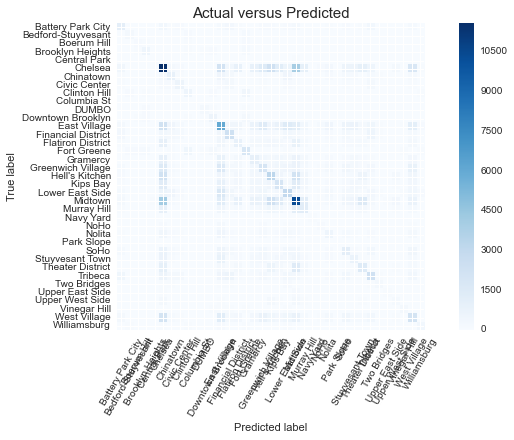

In [94]:
# Confusion matrix (without normalization)

np.set_printoptions(precision=2)
print('Actual versus Predicted Destination Neighborhoods (without normalization)')
print(cm_array)
plt.figure(figsize=(10, 6))
plot_confusion_matrix(cm_array)

Normalized confusion matrix
[[ 0.29  0.    0.   ...,  0.01  0.05  0.  ]
 [ 0.    0.28  0.03 ...,  0.01  0.01  0.05]
 [ 0.01  0.02  0.19 ...,  0.02  0.02  0.02]
 ..., 
 [ 0.03  0.01  0.01 ...,  0.19  0.02  0.02]
 [ 0.02  0.    0.   ...,  0.    0.19  0.  ]
 [ 0.01  0.04  0.01 ...,  0.02  0.02  0.26]]


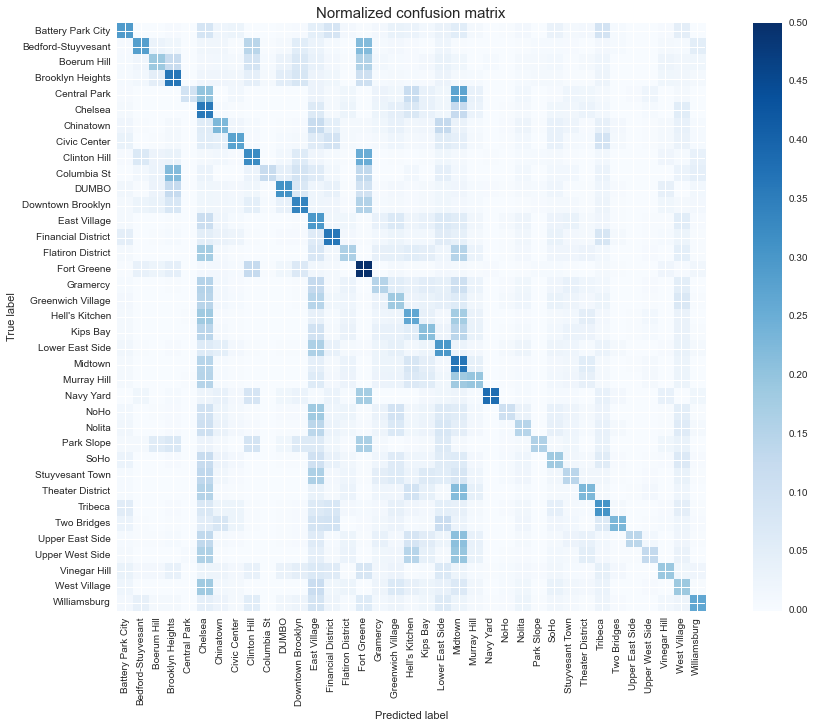

In [101]:
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)

cm_normalized = cm_array.astype('float') / cm_array.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure(figsize=(14, 10))
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

In [168]:
# Create rebalance rate in dataframe for neighborhood ("n2_") and stations ("end_station_id_")

import operator

t = pd.DataFrame(df.groupby("n2_").same_station.value_counts())
d = {}

for n in df.n2_.unique():
    d[n] = ((t.loc[n].iloc[1]).values/((t.loc[n].iloc[0]).values + (t.loc[n].iloc[1]).values))
    
sorted_x = sorted(d.items(), key=operator.itemgetter(1))
sorted_x.reverse()

df_stations = pd.DataFrame(sorted_x)
df_stations.columns = ['Neighborhood','Removal rate']

In [114]:
# Snapshot of bike data on bike 21415

bike_21415 = df[df['bikeid']==21415][['bikeid','stoptime_','end_station_id_','n2_',
                                'starttime','start_station_id','n1','same_station']]
bike_21415